### Import library

In [1]:
import cv2 as cv
import numpy as np 
from matplotlib import pyplot as plt

### GaussianMask

In [2]:
def gaussianMask(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    g /= np.sum(g)
    return g
    

### convolving

In [3]:
def convolute(image, kernel):
    pad=len(kernel)//2
    h=len(image)+2*pad
    w=len(image[0])+2*pad

    padimg=np.pad(image,pad)
    output = np.zeros([h-2*pad, w-2*pad])
    for x in range(pad,h-pad):
        for y in range(pad,w-pad):
            k = padimg[x-pad:x+pad+1, y-pad:y+pad+1]
            output[x-pad][y-pad]=np.sum(k*kernel)

    return output

### Sobel

In [4]:
def sobel(image):
    
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)
    Gx = convolute(image, Kx)
    Gy = convolute(image, Ky)
    
    G = np.sqrt(np.square(Gx) + np.square(Gy))
    
    G = G * image.max() / G.max()
    
    angles = np.arctan2(Gy, Gx) * 180 / np.pi

    G = G
    return (G, angles)

### prewitt

In [5]:
def prewitt(image):
    Kx = [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]
    Ky = [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]
    Gx = convolute(image, Kx)
    Gy = convolute(image, Ky)
    
    
    G = np.hypot(Gx, Gy)
    
    m = G.max()
    G *= image.max() / m
    
    cv.imshow('prewitt', G)
    cv.waitKey(0)
    
    return G

### nonMaximaSuppression

In [6]:
def nonMaximaSuppression(mag, angle):
    M, N = mag.shape
    Non_max = np.zeros((M,N))

    for i in range(1,M-1):
        for j in range(1,N-1):
            # Horizontal = 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
                b = mag[i, j+1]
                c = mag[i, j-1]
            # Diagonal = 45
            elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
                b = mag[i+1, j+1]
                c = mag[i-1, j-1]
            # Vertical = 90
            elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
                b = mag[i+1, j]
                c = mag[i-1, j]
            # Diagonal 135
            elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
                b = mag[i+1, j-1]
                c = mag[i-1, j+1]           
                
            # Non-max Suppression
            if (mag[i,j] >= b) and (mag[i,j] >= c):
                Non_max[i,j] = mag[i,j]
            else:
                Non_max[i,j] = 0
    return Non_max

### Threshold

In [7]:
def Threshold(image, low=0.05, high=0.20):
    img = image.copy()
    low = img.max() * low
    high = img.max() * high
    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            pixel = image[i][j]
            if(pixel >= high): pixel = 255
            elif (pixel <= low): pixel = 0
            else: pixel = 128
            img[i][j] = pixel
    return img

### edgeLinking

In [8]:
def edgeLinking(image):
    img = image.copy()
    rows, cols = img.shape
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            pixel = img[row][col]
            if(pixel > 127 and pixel < 129):
                if (image[row][col+1] >= 129): pixel = 255
                elif (image[row-1][col+1] >= 129): pixel = 255
                elif (image[row+1][col+1] >= 129): pixel = 255
                
                elif (image[row-1][col] >= 129): pixel = 255
                elif (image[row+1][col] >= 129): pixel = 255
                
                elif (image[row-1][col-1] >= 129): pixel = 255
                elif (image[row+1][col-1] >= 129): pixel = 255
                elif (image[row][col-1] >= 129): pixel = 255
                else: pixel = 0
                
                img[row][col] = pixel
    return img


### Canny

In [9]:
def canny(image):
    
    img = image.copy()
    img = convolute(img, gaussianMask(3))
    img, angles = sobel(img)
    img = nonMaximaSuppression(img, angles)
    img = Threshold(img)
    img = edgeLinking(img)
    
    return img

### the main code

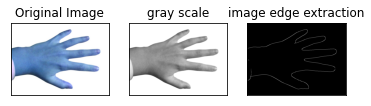

In [10]:
# Read the image
img0 = cv.imread('C:\\Users\\moham\\OneDrive\\Desktop\\test.jpg')
# Convert to gray scale (BGR2GRAY)
img = cv.cvtColor(img0, cv.COLOR_BGR2GRAY)

#the canny
img2=canny(img)
#the prewitt
#prewitt(img)

titles = ['Original Image','gray scale','image edge extraction']
images = [img0,img, img2]
for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()